In [ ]:
# !pip install transformers==4.40.1
# !pip install torch torchvision torchaudio
# !pip install tqdm pandas numpy matplotlib pillow


In [ ]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, GPT2Tokenizer, GPT2LMHeadModel
from transformers import AdamW, get_scheduler
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.7.0+cpu
CUDA available: False


In [4]:
conda --version


conda 23.7.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
IMAGE_DIR = "Images"
# CAPTIONS_FILE = pd.read_csv("http://localhost:8890/edit/captions.txt")
# DEVICE = torch.device("cpu")  # Forced to CPU since CUDA is not available

In [6]:
CAPTIONS_FILE = pd.read_csv("captions.txt")

In [7]:
CAPTIONS_FILE.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [8]:
# DEVICE = torch.device("cpu")  # Forced to CPU since CUDA is not available

In [9]:
data = CAPTIONS_FILE
data['caption'] = data['caption'].str.lower().str.replace("[^a-z ]", "").str.strip()
data['caption'] = "<|startoftext|> " + data['caption'] + " <|endoftext|>"
data.drop_duplicates(inplace=True)

In [10]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_model.resize_token_embeddings(len(tokenizer))
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

C:\Users\91955\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
def extract_clip_features(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        outputs = clip_model.get_image_features(**inputs)
    return outputs.squeeze(0).cpu()  # Detach and move to CPU

In [12]:
class CaptionDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(IMAGE_DIR, row['image'])
        image_features = extract_clip_features(img_path)  # tensor [512]
        caption = row['caption']
        tokenized = tokenizer(caption, return_tensors="pt", padding="max_length", truncation=True, max_length=40)
        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)
        return image_features, input_ids, attention_mask

In [13]:
class ClipCaptionModel(nn.Module):
    def __init__(self, gpt2_model):
        super().__init__()
        self.prefix_project = nn.Linear(512, gpt2_model.config.n_embd)
        self.gpt2 = gpt2_model

    def forward(self, img_feat, input_ids, attention_mask):
        # Project image features
        prefix_embed = self.prefix_project(img_feat).unsqueeze(1)  # [B, 1, 768]
        text_embed = self.gpt2.transformer.wte(input_ids)          # [B, T, 768]

        # Concatenate prefix + token embeddings
        inputs_embeds = torch.cat([prefix_embed, text_embed], dim=1)  # [B, T+1, 768]

        # Extend attention mask for prefix token
        prefix_mask = torch.ones((attention_mask.size(0), 1), dtype=attention_mask.dtype).to(DEVICE)
        extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

        # Pad labels with -100 in prefix position (so GPT2 ignores it)
        pad = torch.full((input_ids.size(0), 1), -100).to(DEVICE)  # shape [B, 1]
        labels = torch.cat([pad, input_ids], dim=1)  # [B, T+1]

        # Forward pass
        outputs = self.gpt2(inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask, labels=labels)
        return outputs.loss



In [ ]:
# train_dataset = CaptionDataset(data)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# model = ClipCaptionModel(gpt2_model).to(DEVICE)
# optimizer = AdamW(model.parameters(), lr=5e-5)
# scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

# losses = []
# for epoch in range(5):
#     model.train()
#     total_loss = 0
#     for step, (img_feat, input_ids, attention_mask) in enumerate(tqdm(train_loader)):
#         img_feat = img_feat.to(DEVICE)
#         input_ids = input_ids.to(DEVICE)
#         attention_mask = attention_mask.to(DEVICE)

#         loss = model(img_feat, input_ids, attention_mask)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()
#         optimizer.zero_grad()

#         total_loss += loss.item()

#         # ✅ OPTIONAL: Save checkpoint every 100 steps
#         if step % 100 == 0:
#             torch.save(model.state_dict(), f"clip_gpt2_step{step}_epoch{epoch+1}.pth")

#     # ✅ SAVE MODEL AT THE END OF EACH EPOCH
#     torch.save(model.state_dict(), f"clip_gpt2_epoch{epoch+1}.pth")

#     avg_loss = total_loss / len(train_loader)
#     losses.append(avg_loss)
#     print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


In [ ]:
import os
os.path.exists("clip_gpt2_epoch5.pth")



In [ ]:
import glob

glob.glob("*.pth")


In [ ]:
import os
from transformers import AdamW, get_scheduler

# ✅ Skip training if model is already trained
if os.path.exists("clip_gpt2_epoch5.pth"):
    print("✅ Model already trained. Skipping training.")
else:
    # DataLoader
    train_dataset = CaptionDataset(data)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

    # Model and optimizer
    model = ClipCaptionModel(gpt2_model).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

    losses = []
    for epoch in range(5):
        model.train()
        total_loss = 0

        for step, (img_feat, input_ids, attention_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            img_feat = img_feat.to(DEVICE)
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)

            loss = model(img_feat, input_ids, attention_mask)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

            # ✅ Optional: Save every 100 steps
            if step % 100 == 0:
                torch.save(model.state_dict(), f"clip_gpt2_step{step}_epoch{epoch+1}.pth")

        # ✅ Save model after each epoch
        torch.save(model.state_dict(), f"clip_gpt2_epoch{epoch+1}.pth")

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # ✅ Save final model explicitly
    torch.save(model.state_dict(), "clip_gpt2_final.pth")

    # ✅ Write a done-flag
    with open("training_done.txt", "w") as f:
        f.write("done")

    print("✅ Training completed and saved as clip_gpt2_final.pth")


In [ ]:
import os
from transformers import AdamW, get_scheduler
from tqdm import tqdm
import torch

# === Resume from checkpoint ===
checkpoint_path = "clip_gpt2_step5000_epoch1.pth"  # your latest saved file
start_epoch = 3  # Since you were in Epoch 4 (0-indexed)

# Rebuild full model (gpt2_model already loaded above)
model = ClipCaptionModel(gpt2_model).to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

# DataLoader
train_dataset = CaptionDataset(data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer,
                          num_warmup_steps=0,
                          num_training_steps=len(train_loader) * 5)

# Global step for saving every 100 steps
global_step = start_epoch * len(train_loader)
losses = []

# === Resume training ===
for epoch in range(start_epoch, 5):
    model.train()
    total_loss = 0

    for step, (img_feat, input_ids, attention_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        img_feat = img_feat.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        loss = model(img_feat, input_ids, attention_mask)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if global_step % 100 == 0:
            torch.save(model.state_dict(), f"clip_gpt2_step{global_step}_epoch{epoch+1}.pth")

        global_step += 1

    torch.save(model.state_dict(), f"clip_gpt2_epoch{epoch+1}.pth")
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} completed — Loss: {avg_loss:.4f}")

# === Final save ===
torch.save(model.state_dict(), "clip_gpt2_final.pth")
with open("training_done.txt", "w") as f:
    f.write("done")

print("✅ Training fully completed and final model saved.")


In [ ]:
import glob

glob.glob("*.pth")

In [ ]:
%matplotlib inline


In [14]:
from PIL import Image
import torch

# === Load trained model ===
model = ClipCaptionModel(gpt2_model).to(DEVICE)
model.load_state_dict(torch.load("clip_gpt2_step4000_epoch1.pth", map_location=DEVICE))
model.eval()

# === Load image ===
image_path = r"C:\Users\91955\Downloads\majorproj_dataset\Images\472535997_0dbf42b9f3.jpg" # ⬅️ Replace with your test image path 
image = Image.open(image_path).convert("RGB")

# === Extract CLIP features ===
with torch.no_grad():
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    image_features = clip_model.get_image_features(**inputs)  # [1, 512]

# === Generate caption ===
def generate_caption(image_features, max_length=40):
    generated = tokenizer("<|startoftext|>", return_tensors="pt").input_ids.to(DEVICE)

    # 🟢 Project image features using prefix_project to match GPT2 embedding size
    img_feat = model.prefix_project(image_features)  # [1, 768]
    img_feat = img_feat.unsqueeze(1)  # [1, 1, 768] → only one unsqueeze!

    for _ in range(max_length):
          with torch.no_grad():
            if generated.dim() == 1:
                generated = generated.unsqueeze(0)
            text_embeds = model.gpt2.transformer.wte(generated)  # [1, T, 768]
            concat = torch.cat([img_feat, text_embeds], dim=1)   # [1, T+1, 768]

            outputs = model.gpt2(inputs_embeds=concat)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated = torch.cat((generated, next_token), dim=1)

    caption = tokenizer.decode(generated[0], skip_special_tokens=True)
    return caption.replace("<|startoftext|>", "").strip()


# === Run captioning ===
caption = generate_caption(image_features)
print(f"🖼️ Generated Caption: {caption}")




🖼️ Generated Caption: two girls are playing in a pool.


In [ ]:
print(f"Image size: {image.size}")
print(f"Caption: {caption}")


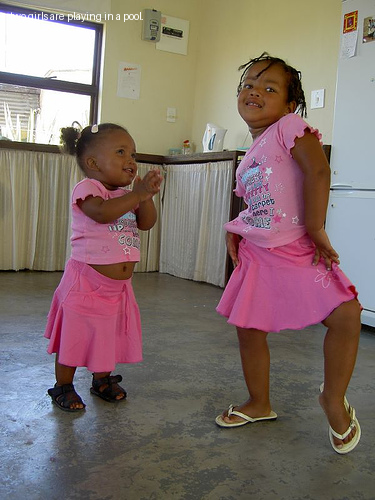

In [15]:
from IPython.display import display
from PIL import ImageDraw, ImageFont

# Simple overlay (optional)
image_copy = image.copy()
draw = ImageDraw.Draw(image_copy)
draw.text((10, 10), caption, fill="white")

# Display
display(image_copy)


In [ ]:
import os
import re
from tqdm import tqdm
import torch
from transformers import AdamW, get_scheduler

# === Load correct checkpoint ===
checkpoint_path = "clip_gpt2_step4000_epoch1.pth"  # <-- update this as needed

# === Extract global_step and start_epoch ===
match = re.search(r"step(\d+)_epoch(\d+)", checkpoint_path)
if match:
    global_step = int(match.group(1))         # 4000
    start_epoch = int(match.group(2)) - 1     # 0-based epoch
else:
    raise ValueError("Bad checkpoint filename")

# === Load model and weights ===
model = ClipCaptionModel(gpt2_model).to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))

# === Reload dataset and optimizer ===
train_dataset = CaptionDataset(data)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer,
                          num_warmup_steps=0,
                          num_training_steps=5056)  # final total

losses = []

# === Train only from 4000 to 5056 ===
for epoch in range(start_epoch, 5):
    model.train()
    total_loss = 0

    for step, (img_feat, input_ids, attention_mask) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", total=len(train_loader))):
        if global_step >= 5056:
            break  # 🚨 Stop once 5056 is reached

        img_feat = img_feat.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        loss = model(img_feat, input_ids, attention_mask)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if global_step % 100 == 0:
            torch.save(model.state_dict(), f"clip_gpt2_step{global_step}_epoch{epoch+1}.pth")

        global_step += 1

    torch.save(model.state_dict(), f"clip_gpt2_epoch{epoch+1}.pth")
    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"✅ Epoch {epoch+1} completed — Loss: {avg_loss:.4f}")

# ✅ Final save
torch.save(model.state_dict(), "clip_gpt2_final.pth")
print("✅ Training completed from step 4000 to 5056.")


In [ ]:
import glob

glob.glob("*.pth")

🖼️ 2984704498_29b53df5df.jpg: a woman in a red shirt and a black jacket is standing in front of a store.


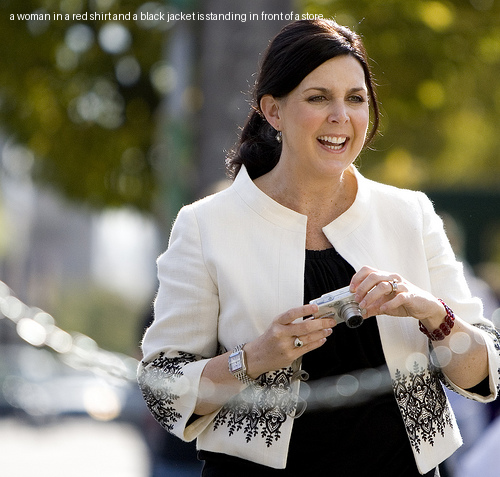

🖼️ 3542484764_77d8920ec9.jpg: a man in a white shirt is playing cricket.


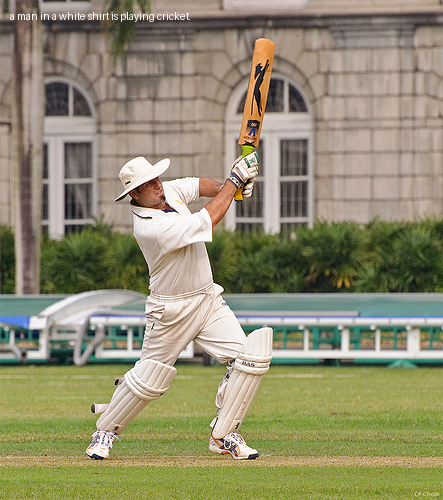

🖼️ 1470132731_fa416b7504.jpg: a black dog is running through the water.


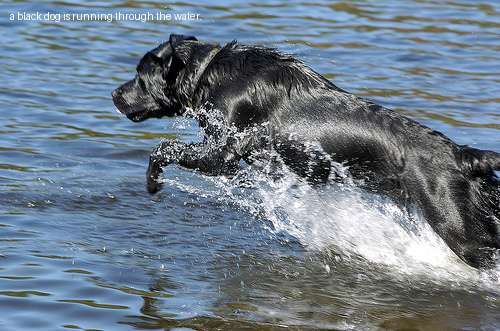

🖼️ 1220401002_3f44b1f3f7.jpg: two girls are playing in a grassy yard.


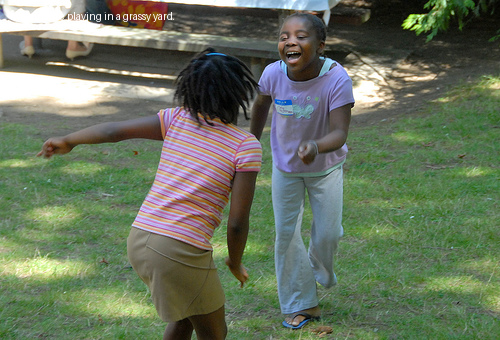

🖼️ 3090386315_87ed417814.jpg: a brown dog is running through the grass.


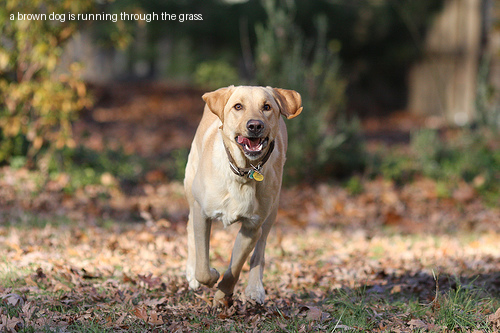

🖼️ 381275595_b429fd1639.jpg: a brown dog is playing with a red ball in a green room.


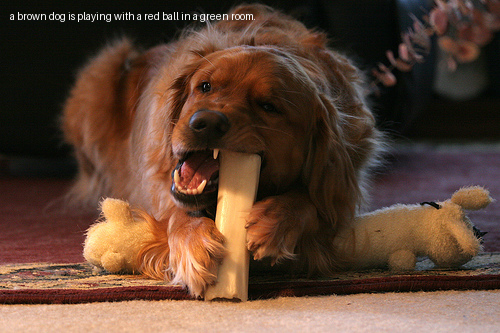

🖼️ 3195040792_a03954a19f.jpg: two dogs run through the snow.


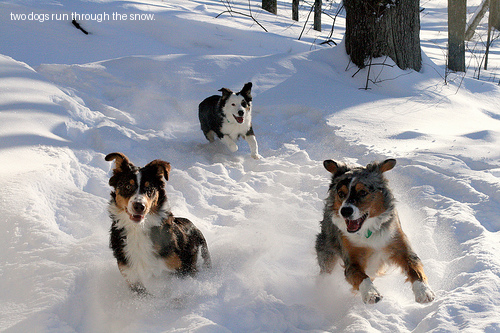

🖼️ 2896298341_92d718366a.jpg: a girl in a pink shirt is running in the grass.


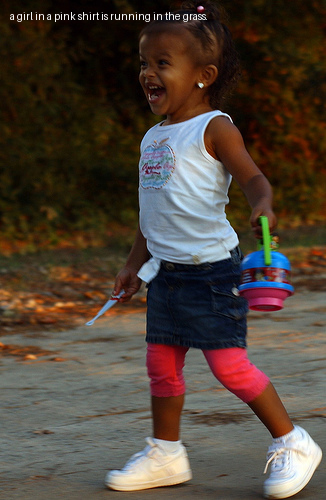

🖼️ 3127888173_9a9a8ac3bd.jpg: a group of children are playing in a field.


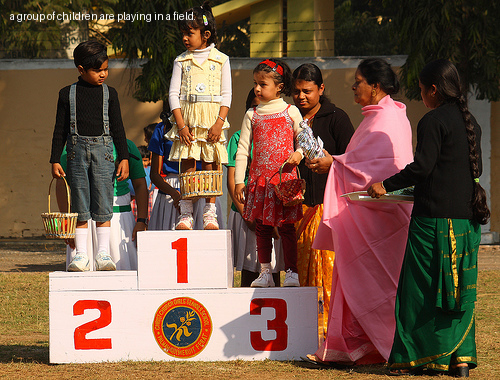

🖼️ 3157847991_463e006a28.jpg: two men are sitting on a balcony.


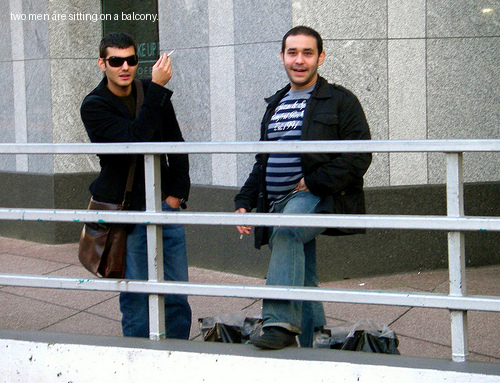

In [16]:
import os
import random
from PIL import Image, ImageDraw
from IPython.display import display
import torch
from tqdm import tqdm

# === Folder containing test images ===
image_folder = r"C:\Users\91955\Downloads\majorproj_dataset\Images"

# === Load model checkpoint ===
model = ClipCaptionModel(gpt2_model).to(DEVICE)
model.load_state_dict(torch.load("clip_gpt2_final.pth", map_location=DEVICE))  # ✅ Replace with latest .pth
model.eval()

# === Caption generation function ===
def generate_caption(image_features, max_length=40):
    generated = tokenizer("<|startoftext|>", return_tensors="pt").input_ids.to(DEVICE)
    img_feat = model.prefix_project(image_features)  # [1, 768]
    img_feat = img_feat.unsqueeze(1)  # [1, 1, 768]

    for _ in range(max_length):
        with torch.no_grad():
            text_embeds = model.gpt2.transformer.wte(generated)
            concat = torch.cat([img_feat, text_embeds], dim=1)
            outputs = model.gpt2(inputs_embeds=concat)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            if next_token.item() == tokenizer.eos_token_id:
                break

            generated = torch.cat((generated, next_token), dim=1)

    caption = tokenizer.decode(generated[0], skip_special_tokens=True)
    return caption.replace("<|startoftext|>", "").strip()

# === Get 10 random image files ===
all_images = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
sample_images = random.sample(all_images, 10)

# === Loop through selected images ===
for filename in sample_images:
    image_path = os.path.join(image_folder, filename)
    image = Image.open(image_path).convert("RGB")

    # Extract image features using CLIP
    with torch.no_grad():
        inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
        image_features = clip_model.get_image_features(**inputs)

    # Generate caption
    caption = generate_caption(image_features)

    # Overlay caption on image
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)
    draw.text((10, 10), caption, fill="white")

    # Display image with caption
    print(f"🖼️ {filename}: {caption}")
    display(image_copy)


In [23]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm

# Make sure to download punkt tokenizer once
nltk.download('punkt')

def generate_caption(model, image_features, tokenizer, max_length=40):
    model.eval()
    generated = []
    
    with torch.no_grad():
        # Project image features
        prefix_embed = model.prefix_project(image_features.to(DEVICE)).unsqueeze(1)  # [1,1,768]

        # Start with <|startoftext|> token
        input_ids = tokenizer.convert_tokens_to_ids("<|startoftext|>")
        input_ids = torch.tensor([[input_ids]], device=DEVICE)  # Make it [1,1]
        generated = input_ids

        
        for _ in range(max_length):
            text_embed = model.gpt2.transformer.wte(generated)  # [1, seq_len, 768]
            inputs_embeds = torch.cat([prefix_embed, text_embed], dim=1)  # [1, seq_len+1, 768]

            prefix_mask = torch.ones((1, 1), dtype=torch.long).to(DEVICE)
            attention_mask = torch.ones(generated.shape, dtype=torch.long).to(DEVICE)
            extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

            outputs = model.gpt2(inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            if next_token.item() == tokenizer.convert_tokens_to_ids("<|endoftext|>"):
                break
            generated = torch.cat([generated, next_token], dim=1)

        generated_tokens = generated.squeeze().tolist()
        # Decode tokens to string (remove start token)
        caption = tokenizer.decode(generated_tokens[1:], skip_special_tokens=True)
    return caption

# Prepare lists to store references and hypotheses
references = []
hypotheses = []

subset = data.tail(500)  # you can try 200, 300, 1000 based on your system speed
for idx, row in tqdm(subset.iterrows(), total=len(subset)):
    img_path = os.path.join(IMAGE_DIR, row['image'])
    img_feat = extract_clip_features(img_path)  # tensor [512]

    pred_caption = generate_caption(model, img_feat.unsqueeze(0), tokenizer)
    # Clean reference caption (remove special tokens, lower, strip punctuation)
    ref_caption = row['caption'].replace("<|startoftext|>", "").replace("<|endoftext|>", "").strip()
    
    # Tokenize for BLEU
    ref_tokens = nltk.word_tokenize(ref_caption.lower())
    pred_tokens = nltk.word_tokenize(pred_caption.lower())
    
    references.append([ref_tokens])  # list of list of reference tokens
    hypotheses.append(pred_tokens)

# Calculate BLEU score with smoothing
smooth_fn = SmoothingFunction().method1
bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smooth_fn)

print(f"Corpus BLEU score on full dataset: {bleu_score:.4f}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [09:06<00:00,  1.09s/it]

Corpus BLEU score on full dataset: 0.0442


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [20:34<00:00,  1.03s/it]


Average METEOR score on dataset: 0.1808


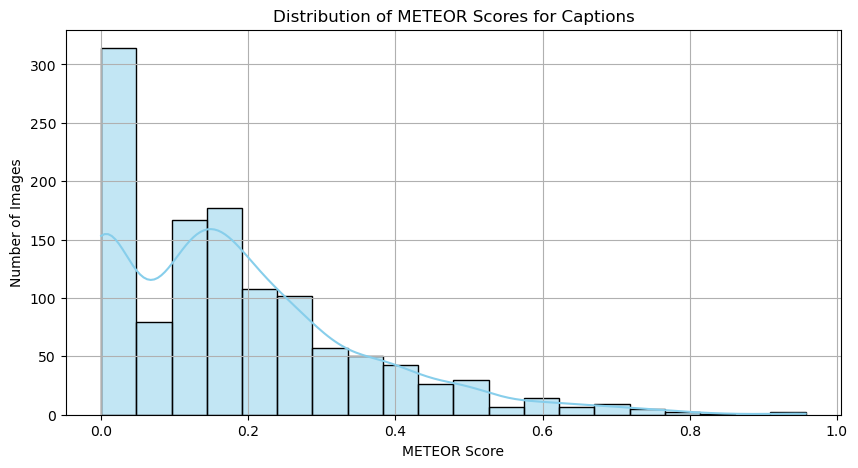

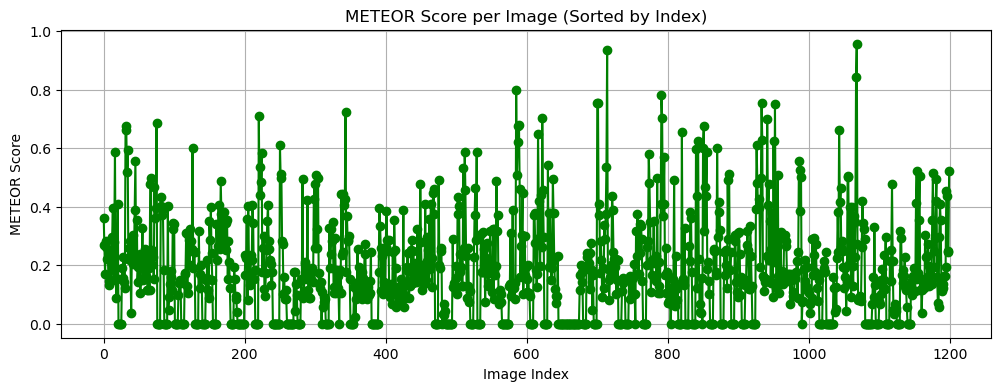

In [24]:
import nltk
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import torch
import os

# Make sure punkt is available for tokenization
nltk.download('punkt')
nltk.download('wordnet')  # Required for METEOR

def generate_caption(model, image_features, tokenizer, max_length=40):
    model.eval()
    
    with torch.no_grad():
        prefix_embed = model.prefix_project(image_features.to(DEVICE)).unsqueeze(1)  # [1,1,768]

        input_ids = tokenizer.convert_tokens_to_ids("<|startoftext|>")
        input_ids = torch.tensor([[input_ids]], device=DEVICE)  # Shape: [1, 1]
        generated = input_ids

        for _ in range(max_length):
            text_embed = model.gpt2.transformer.wte(generated)
            inputs_embeds = torch.cat([prefix_embed, text_embed], dim=1)

            prefix_mask = torch.ones((1, 1), dtype=torch.long).to(DEVICE)
            attention_mask = torch.ones(generated.shape, dtype=torch.long).to(DEVICE)
            extended_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)

            outputs = model.gpt2(inputs_embeds=inputs_embeds, attention_mask=extended_attention_mask)
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            if next_token.item() == tokenizer.convert_tokens_to_ids("<|endoftext|>"):
                break
            generated = torch.cat([generated, next_token], dim=1)

        generated_tokens = generated.squeeze().tolist()
        caption = tokenizer.decode(generated_tokens[1:], skip_special_tokens=True)

    return caption

references = []
hypotheses = []

subset = data.tail(1200)  # adjust as needed

for idx, row in tqdm(subset.iterrows(), total=len(subset)):
    img_path = os.path.join(IMAGE_DIR, row['image'])
    img_feat = extract_clip_features(img_path)  # tensor [512]

    pred_caption = generate_caption(model, img_feat.unsqueeze(0), tokenizer)
    ref_caption = row['caption'].replace("<|startoftext|>", "").replace("<|endoftext|>", "").strip()

    # Tokenize captions to list of tokens (for METEOR)
    ref_tokens = nltk.word_tokenize(ref_caption.lower())
    pred_tokens = nltk.word_tokenize(pred_caption.lower())

    references.append(ref_tokens)
    hypotheses.append(pred_tokens)

meteor_scores = []
for ref_tokens, hyp_tokens in zip(references, hypotheses):
    # meteor_score expects list of references (each a list of tokens) and hypothesis list of tokens
    score = meteor_score([ref_tokens], hyp_tokens)  # note: [ref_tokens] is a list of references
    meteor_scores.append(score)

avg_meteor = sum(meteor_scores) / len(meteor_scores)
print(f"Average METEOR score on dataset: {avg_meteor:.4f}")



import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of METEOR scores
plt.figure(figsize=(10, 5))
sns.histplot(meteor_scores, bins=20, kde=True, color='skyblue')
plt.title("Distribution of METEOR Scores for Captions")
plt.xlabel("METEOR Score")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()

# Line plot of METEOR scores by sample index
plt.figure(figsize=(12, 4))
plt.plot(meteor_scores, marker='o', linestyle='-', color='green')
plt.title("METEOR Score per Image (Sorted by Index)")
plt.xlabel("Image Index")
plt.ylabel("METEOR Score")
plt.grid(True)
plt.show()


In [25]:
!pip install bert-score
!git clone https://github.com/tylin/coco-caption.git
%cd coco-caption
!pip install -e .
%cd ..


C:\Users\91955\Downloads\majorproj_dataset\coco-caption


fatal: destination path 'coco-caption' already exists and is not an empty directory.


Obtaining file:///C:/Users/91955/Downloads/majorproj_dataset/coco-caption
C:\Users\91955\Downloads\majorproj_dataset


ERROR: file:///C:/Users/91955/Downloads/majorproj_dataset/coco-caption does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [26]:
!git clone https://github.com/tylin/coco-caption.git


fatal: destination path 'coco-caption' already exists and is not an empty directory.


In [27]:
%cd coco-caption
!pip install -e .
%cd ..


C:\Users\91955\Downloads\majorproj_dataset\coco-caption
Obtaining file:///C:/Users/91955/Downloads/majorproj_dataset/coco-caption
C:\Users\91955\Downloads\majorproj_dataset


ERROR: file:///C:/Users/91955/Downloads/majorproj_dataset/coco-caption does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [28]:
import sys
sys.path.append('./coco-caption/pycocoevalcap')

In [29]:
!pip install bert-score


In [30]:
import nltk
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm
import torch
import os

nltk.download('punkt')
nltk.download('wordnet')

references = []
hypotheses = []

subset = data.tail(1200)  # Or full dataset

for idx, row in tqdm(subset.iterrows(), total=len(subset)):
    img_path = os.path.join(IMAGE_DIR, row['image'])
    img_feat = extract_clip_features(img_path)  # tensor [512]

    pred_caption = generate_caption(model, img_feat.unsqueeze(0), tokenizer)
    ref_caption = row['caption'].replace("<|startoftext|>", "").replace("<|endoftext|>", "").strip()

    references.append(ref_caption)
    hypotheses.append(pred_caption)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91955\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [20:32<00:00,  1.03s/it]


ImportError: attempted relative import with no known parent package

In [42]:
import sys
sys.path.append(r'C:/Users/91955/Downloads/majorproj_dataset/coco-caption')




In [46]:
import importlib
import pycocoevalcap.cider.cider_scorer as cider_scorer
importlib.reload(cider_scorer)
import pycocoevalcap.cider.cider as cider_module
importlib.reload(cider_module)


<module 'pycocoevalcap.cider.cider' from 'C:\\Users/91955/Downloads/majorproj_dataset/coco-caption\\pycocoevalcap\\cider\\cider.py'>

In [47]:
from pycocoevalcap.cider.cider import Cider

# Prepare input format for CIDEr scorer
gts = {}  # ground truth references
res = {}  # generated predictions

for i, (ref, hyp) in enumerate(zip(references, hypotheses)):
    gts[i] = [ref]
    res[i] = [hyp]

# Run CIDEr
cider_scorer = Cider()
cider_score, _ = cider_scorer.compute_score(gts, res)

print(f"Average CIDEr score: {cider_score:.4f}")


Average CIDEr score: 0.1773


In [32]:
from bert_score import score

P, R, F1 = score(hypotheses, references, lang="en", verbose=True)
print(f"Average BERTScore F1: {F1.mean():.4f}")


C:\Users\91955\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

C:\Users\91955\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\91955\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/22 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/19 [00:00<?, ?it/s]

done in 78.37 seconds, 15.31 sentences/sec
Average BERTScore F1: 0.6686


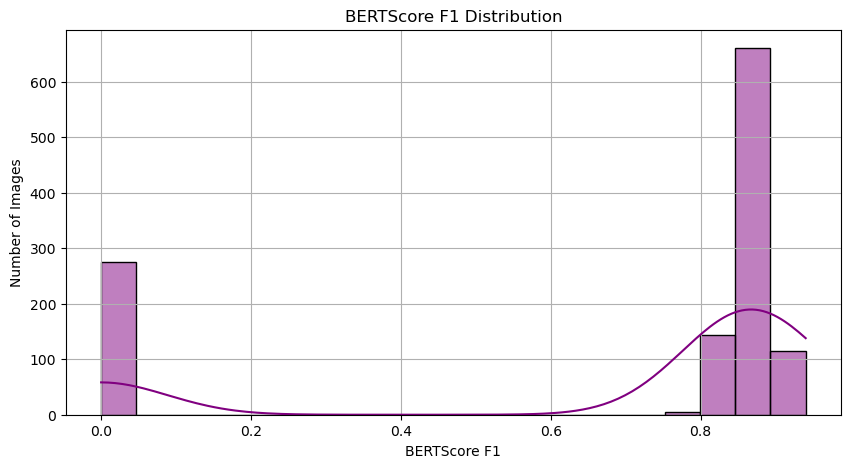

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(F1.tolist(), bins=20, kde=True, color='purple')
plt.title("BERTScore F1 Distribution")
plt.xlabel("BERTScore F1")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()


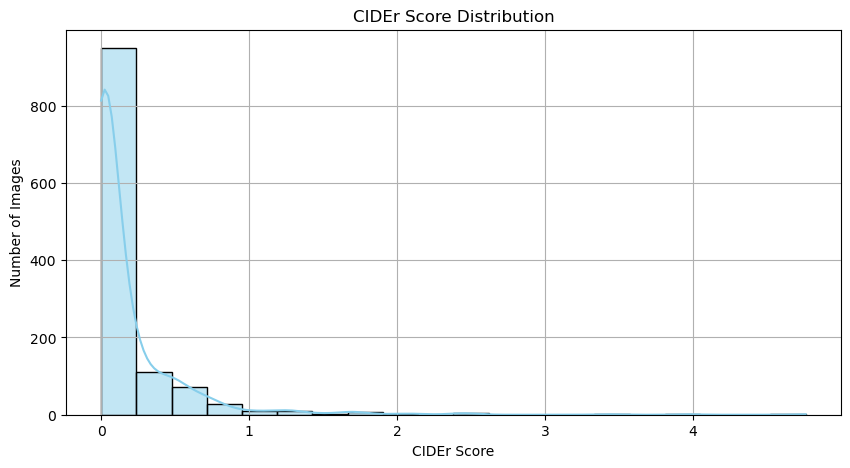

In [49]:
# Run with return individual scores
_, cider_scores = cider_scorer.compute_score(gts, res)

plt.figure(figsize=(10, 5))
sns.histplot(cider_scores, bins=20, kde=True, color='skyblue')
plt.title("CIDEr Score Distribution")
plt.xlabel("CIDEr Score")
plt.ylabel("Number of Images")
plt.grid(True)
plt.show()
